In [1]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message

/Users/adityanatani/Documents/workspace/ai-engineering-bootcamp-prerequisite/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
qdrant_client = QdrantClient(url="http://localhost:6333")


In [3]:
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

In [4]:
def retrieve_data(query, qdrant_client, k=5):

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    return {
        "retrieved_context_ids": retrieved_context_ids,
        "retrieved_context": retrieved_context,
        "retrieved_context_ratings": retrieved_context_ratings,
        "similarity_scores": similarity_scores,
    }

In [5]:
query = "Can I get a tablet?"


In [6]:
answer = retrieve_data(query, qdrant_client, k=10)


Fetching 18 files: 100%|██████████| 18/18 [00:00<00:00, 19.63it/s]


In [7]:
answer

{'retrieved_context_ids': ['B0B8NVNQKX',
  'B0B6VMB3D1',
  'B0BN7WWH63',
  'B0C1NP5KYD',
  'B0BR33XH8D',
  'B09LH466KZ',
  'B0BL2CZSHT',
  'B0B6ZZH83Y',
  'B0BFGXRMJN',
  'B0B4WCNWF3'],
 'retrieved_context': ['COOPERS 7 inch Kids Tablet Android 11 Tablet for Kids, 2GB RAM + 32GB ROM Toddler Tablet PC for Children, IPS Touch Screen, Dual Camera, Dual Speaker, WiFi Computer Tablet, Light Blue ✿【Good Kids tablet】This 7 inch tablet for kids with silm body and lightweight, it is easy to hold by children. Also the special design can protect the tablet well when dropping. ✿【Parental Control】Toddlers Tablet with parent mode can add or block apps. Set screen time limits. This tablet come with iwawa app. kids can get access to fun and educational games and videos. ✿【Powerful Tablets】Equipmented with quad core CPU, Android 11.0 System, 32GB Big Storage, 1024*600 IPS Screen offer a clear view. Runs Kinds of apps and game for kids smoothly. ✿【Long Lasting】Tablet for kids built with large capacity b

### MultiIntent Questions ###

In [8]:
query = "Can I get a tablet for my kid, watch for me and laptop for my wife"

In [9]:
answer = retrieve_data(query, qdrant_client, k=10)

In [10]:
answer

{'retrieved_context_ids': ['B0BRXZDBXZ',
  'B0BL2CZSHT',
  'B0B8NVNQKX',
  'B0C142QS8X',
  'B0C3XYD574',
  'B0BFGXRMJN',
  'B0BCQ8RJG7',
  'B09XQGN52P',
  'B09Q8FLNDR',
  'B0C772GZRF'],
 'retrieved_context': ["Kids Tablet, 7 inch Tablet for Kids 3GB RAM 32GB ROM, Android 11 Toddler Tablet with WiFi, Bluetooth, GMS, Parental Control, Shockproof Case, Google Play, YouTube, Netflix 【iWawa APP with parental control】This kids tablet has passed the GMS certification and is pre-installed with the iwawa app, specially designed for children. It has password control, remote video control, one-button lock screen and Learning, art, smart games. New-upgrade kids online school, fun interaction, video playback 【Android 11.0 & 128 GB Expand】Android 11.0 operating system, 3GB RAM 32GB ROM, support WiFi, Bluetooth, GPS, etc. The HD 1024*600IPS display can offer a perfect experience, You can expand the storage to 128 GB of SD cards for storing photos, music and videos. The upgraded battery can last more 

In [11]:
class QueryExpandResponse(BaseModel):
   statements: List[str]

In [12]:
def query_expand_node(query) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "queries": response.statements
   }

In [13]:
answer = query_expand_node(query)

In [14]:
answer

{'queries': ['tablet suitable for kids',
  'watch for adults',
  'laptop for women']}

### LangGraph ###

#### Query Expenstion (Sequential Execution) ####

In [15]:
class State(BaseModel):
    expanded_query:List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""

#### Query Expansion / Rewriting Node ####

In [52]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

In [53]:
@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.
- Be as concise as possible, do not make up synonims for statements, one statement per piece of context.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
   }

In [54]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_data(query, k=5):

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(query)

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return formatted_context


@traceable(
    name="retriever_node",
    run_type="retriever"
)
def retriever_node(state: State) -> dict:

    retrieved_context = []

    for query in state.expanded_query:
        retrieved_context.append(retrieve_data(query, k=5))

    return {
        "retrieved_context": retrieved_context
    }

#### Aggregator Node ####

In [55]:

class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [56]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

In [57]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_edge("query_expand_node", "retriever_node")
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

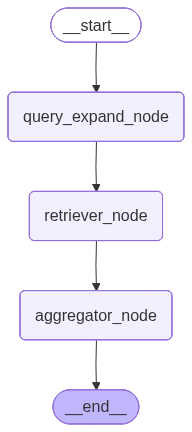

In [58]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [59]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query,
}

In [60]:
result = graph.invoke(initial_state)

In [61]:
result

{'expanded_query': ['tablet for kid', 'watch for adult', 'laptop for wife'],
 'retrieved_context': ['- ID: B0C3XYD574, rating: 4.4, description: ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue) 【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core processor, 2GB RAM & 32GB ROM storage, dual 

In [62]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are the detailed options:

Tablet for your kid:
- ROWT Tablet for Kids 10 inch
  - 10.1-inch HD 1280x800 IPS touchscreen
  - Android 11 OS
  - 2GB RAM, 32GB ROM
  - 6000mAh battery
  - GMS-certified with parental controls
  - Kid-proof case with built-in stand
  - Dual cameras, Wi-Fi, Bluetooth

Watch for you:
- BJNAAL Smart Watch
  - 1.69" large screen
  - IP68 waterproof
  - Fitness tracker with blood pressure, sleep monitor, step counter, calories burned
  - 25 sports modes
  - Compatible with iOS 9.0 & Android 4.4+
  - 340mAh battery with 7 days working time
  - Practical tools like timer, calculator, music & camera controller

Laptop for your wife:
- Lenovo Newest Ideapad 15.6" Laptop
  - 15.6 inch HD IPS display with 1366 x 768 resolution
  - AMD Athlon Silver 3050U dual-core processor
  - 4GB DDR4 RAM
  - 128GB PCIe SSD storage
  - WiFi 6 and Bluetooth 5.0
 

#### Query Expension ####

In [63]:
class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[str], add] = []
    initial_query: str = ""
    answer: str = ""
    query: str = ""
    k: int = 10

#### Query Expansion / Rewriting Node ####

In [64]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

In [65]:
@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
- The statements should not overlap in context.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=QueryExpandResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "expanded_query": response.expanded_query
   }

In [66]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retrieve_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

In [67]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding


@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retrieve_node(state, k=5):

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state["query"])

    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=query,
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=k,
    )

    retrieved_context_ids = []
    retrieved_context = []
    similarity_scores = []
    retrieved_context_ratings = []

    for result in results.points:
        retrieved_context_ids.append(result.payload["parent_asin"])
        retrieved_context.append(result.payload["description"])
        retrieved_context_ratings.append(result.payload["average_rating"])
        similarity_scores.append(result.score)

    formatted_context = ""

    for id, chunk, rating in zip(retrieved_context_ids, retrieved_context, retrieved_context_ratings):
        formatted_context += f"- ID: {id}, rating: {rating}, description: {chunk}\n"

    return {
        "retrieved_context": [formatted_context]
    }


#### Aggregator Node ####

In [68]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

In [69]:
@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = "\n".join(state.retrieved_context)

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

In [70]:
workflow = StateGraph(State)

workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retrieve_node", retrieve_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "query_expand_node")
workflow.add_conditional_edges("query_expand_node", query_expand_conditional_edges)

workflow.add_edge("retrieve_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

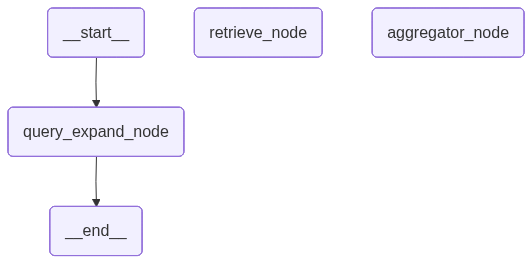

In [71]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
query = "Can I get a tablet for my kid, a watch for me and a laptop for my wife?"
initial_state = {
    "initial_query": query,
}

In [73]:
result = graph.invoke(initial_state)


In [74]:
result

{'expanded_query': ['tablet suitable for kids',
  'smartwatch for adults',
  'laptop for wife'],
 'retrieved_context': ['- ID: B0BL2CZSHT, rating: 4.7, description: All-New 10and 10 Plus 2021 Tablet Case for Kids, Ubearkk Adult & Kids Friendly Light Weight Shock Proof Kid-Proof Back Cover Compatible 101h Generation 2021 Model Compatibility- Designed for All-New ＨＤ 10 & ＨＤ 10 Plus Tablet & ＨＤ 10 Kids Pro Tablet Latest model(Only compatible with 11th Generation, 2021 Release). NOT Fit for other generations. Kids-proof Case-Made with dense heavy duty EVA foam material can withstand considerable wear and tear and provide extreme shock protection. Super light weight and durable hazard free safe material perfect for kids and grownups alike. Built-in Kickstand - Designed with a foldable kick-stand on the back of the case, allows you to set up multiple angles and gives you the hands-free convenience when watching videos and movies. Precise cutouts- Full access to all ports, buttons, and camera

In [75]:
print(result["answer"])

Yes, you can get a tablet for your kid, a watch for yourself, and a laptop for your wife from the available products. Here are the options:

1. Tablet for Kids:
- ROWT Tablet for Kids 10 inch
  - 2GB RAM, 32GB ROM
  - Android 11 OS
  - 6000mAh battery
  - Wi-Fi and Bluetooth
  - Kid-proof case included
  - HD 1280x800 IPS touchscreen
  - Quad-Core 1.6 GHz processor
  - Dual cameras
  - Parental controls and kid-friendly content

2. Smart Watch for Adults:
- Smart Watch, Touch Screen Fitness Tracker
  - 1.69" full touch color screen (240x280 resolution)
  - Heart rate and sleep monitor
  - Waterproof (IP68)
  - 25 sports modes
  - Bluetooth connectivity
  - Notifications for calls, messages, apps
  - Customizable watch faces
  - Up to 7 days battery life

3. Laptop for Wife:
- Lenovo Newest Ideapad 15.6" Laptop
  - AMD Athlon Silver 3050U dual-core processor
  - 4GB DDR4 RAM
  - 128GB PCIe SSD storage
  - 15.6 inch HD IPS display (1366 x 768 resolution)
  - WiFi 6 and Bluetooth 5.0
  - 